# SPS MBB Dipole -- NCS Streaming Supercycle Analysis

**Measurement session:** `20260206_144537_SPS_MBB` (extended run)
**Segment:** NCS
**Magnet:** MBB (normal dipole, m=1)
**Kn calibration:** AC compensation (cross-session from MBA, same coil)

This notebook processes a **streaming** measurement where the SPS
supercycle repeats ~20 times.  The rotating coil produces unreliable
harmonics during fast current ramps, so we:

1. Detect **current plateaus** (flat injection + flat tops) from the
   per-turn current stability.
2. Classify each plateau by current level to identify the machine
   cycle type.
3. Process harmonics **only on plateau turns** and average per level.

| Section | Content |
|---------|----------|
| 1 | Configuration & imports |
| 2 | Kn calibration |
| 3 | Raw data loading & per-turn overview |
| 4 | Plateau detection & cycle identification |
| 5 | Raw signals with plateau annotations |
| 6 | Pipeline processing (plateau turns only) |
| 7 | B1 analysis per plateau |
| 8 | Transfer function B/I vs I |
| 9 | b2 (quadrupole) per plateau |
| 10 | b3 (sextupole) per plateau |
| 11 | Summary & export |

---
## 1. Configuration & Imports

In [169]:
# =====================================================================
#  USER-SELECTABLE PARAMETERS  --  edit this section before running
# =====================================================================

# --- Dataset ---
SEGMENT = "NCS"
SESSION = "2026_02_06/01_200_extended/20260206_144537_SPS_MBB"
MEAS_SUBDIR = "20260206_144559_MBB"
KN_CROSS_SESSION = "20251212_171026_SPS_MBA/CRMMMMH_AV-00000001/Kn_values_Seg_Main_A_AC.txt"

# --- Magnet / coil ---
MAGNET_ORDER = 1          # dipole
R_REF = 0.02              # reference radius [m]
L_COIL = 0.47             # coil length [m]
SAMPLES_PER_TURN = 1024   # encoder samples per revolution

# --- Pipeline ---
OPTIONS = ("dri", "rot", "cel", "fed")
MIN_B1_T = 1e-4

# --- Plateau detection ---
# A turn is accepted as "on the plateau" only if the current is FLAT:
#   max(I) - min(I)  <  PLATEAU_I_RANGE_MAX
# Peak-to-peak variation within the entire turn must stay below this.
PLATEAU_I_RANGE_MAX = 3.0   # A  <-- raise to accept more turns, lower to be stricter

# =====================================================================

kn_label = KN_CROSS_SESSION.split("/")[-1]
print(f"SPS MBB Dipole -- {SEGMENT} Streaming Supercycle Analysis")
print("=" * 60)
print(f"  Session       : {SESSION}")
print(f"  Kn file       : {kn_label} (cross-session from MBA)")
print(f"  Magnet order  : {MAGNET_ORDER} (dipole)")
print(f"  Plateau thr   : I range < {PLATEAU_I_RANGE_MAX} A (peak-to-peak)")

SPS MBB Dipole -- NCS Streaming Supercycle Analysis
  Session       : 2026_02_06/01_200_extended/20260206_144537_SPS_MBB
  Kn file       : Kn_values_Seg_Main_A_AC.txt (cross-session from MBA)
  Magnet order  : 1 (dipole)
  Plateau thr   : I range < 3.0 A (peak-to-peak)


In [170]:
import sys
from pathlib import Path
import re, warnings
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

%matplotlib widget
plt.rcParams.update({
    "figure.figsize": (14, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 100,
})

repo_root = Path("../..").resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from rotating_coil_analyzer.analysis.kn_pipeline import (
    load_segment_kn_txt,
)
from rotating_coil_analyzer.analysis.utility_functions import (
    compute_block_averaged_range,
    detect_plateau_turns,
    classify_current,
    find_contiguous_groups,
    process_kn_pipeline,
    build_harmonic_rows,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

print("Imports ready.")

Imports ready.


In [171]:
REPO_ROOT = Path(".").resolve()
while REPO_ROOT != REPO_ROOT.parent:
    if (REPO_ROOT / "pyproject.toml").exists() or (REPO_ROOT / ".git").exists():
        break
    REPO_ROOT = REPO_ROOT.parent

SESSION_DIR = REPO_ROOT / "measurements" / SESSION
RUN_DIR = SESSION_DIR / MEAS_SUBDIR
KN_PATH = REPO_ROOT / "measurements" / KN_CROSS_SESSION

# Find the NCS raw file
FILE_PAT = re.compile(
    r"Run_(\d+)_I_([\d.]+)A_(N?CS)_raw_measurement_data\.txt$"
)
ncs_files = []
for f in sorted(RUN_DIR.iterdir()):
    m = FILE_PAT.search(f.name)
    if m and m.group(3) == SEGMENT:
        ncs_files.append(f)

RAW_FILE = ncs_files[0]
print(f"Repo root   : {REPO_ROOT}")
print(f"Session dir : {SESSION_DIR}")
print(f"Raw file    : {RAW_FILE.name}")
print(f"Kn file     : {KN_PATH}")
assert KN_PATH.exists(), f"Kn file not found: {KN_PATH}"
assert RAW_FILE.exists(), f"Raw file not found: {RAW_FILE}" 

Repo root   : C:\Users\albellel\python-projects\rotating-coil-analyzer
Session dir : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\2026_02_06\01_200_extended\20260206_144537_SPS_MBB
Raw file    : 20260206_144559_MBB_Run_00_I_100.00A_NCS_raw_measurement_data.txt
Kn file     : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\20251212_171026_SPS_MBA\CRMMMMH_AV-00000001\Kn_values_Seg_Main_A_AC.txt


---
## 2. Kn Calibration

In [172]:
kn = load_segment_kn_txt(str(KN_PATH))
H = len(kn.orders)
print(f"Kn: {H} harmonics from {KN_PATH.name} (cross-session)")

kn_abs_n1 = abs(kn.kn_abs[0])
kn_cmp_n1 = abs(kn.kn_cmp[0])
ratio_n1 = kn_abs_n1 / max(kn_cmp_n1, 1e-30)
print(f"  Abs/Cmp suppression (n=1): {ratio_n1:.0f}x")

Kn: 15 harmonics from Kn_values_Seg_Main_A_AC.txt (cross-session)
  Abs/Cmp suppression (n=1): 20268x


---
## 3. Raw Data Loading & Per-Turn Overview

In [173]:
Ns = SAMPLES_PER_TURN
raw = np.loadtxt(RAW_FILE)
n_turns = raw.shape[0] // Ns
n_keep = n_turns * Ns
ncols = raw.shape[1]
print(f"Raw shape: {raw.shape} -> {n_turns} turns, {ncols} columns")
print(f"Time span: {raw[-1,0] - raw[0,0]:.1f} s ({(raw[-1,0] - raw[0,0])/60:.1f} min)")

# Reshape into (n_turns, Ns)
t_all   = raw[:n_keep, 0].reshape(n_turns, Ns)
flux_abs_all = raw[:n_keep, 1].reshape(n_turns, Ns)
flux_cmp_all = raw[:n_keep, 2].reshape(n_turns, Ns)
I_all   = raw[:n_keep, 3].reshape(n_turns, Ns)

# Pick a high-current turn for channel detection
I_mean_quick = I_all.mean(axis=1)
best_turn = np.argmax(np.abs(I_mean_quick))
r1 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 1])
r2 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 2])
SWAP_FLUX = (r2 > r1)
COL_ABS = 2 if SWAP_FLUX else 1
COL_CMP = 1 if SWAP_FLUX else 2
COL_I = 3

# Voltage channel
COL_V = 4 if ncols > 4 else None

# Re-assign flux arrays if swapped
if SWAP_FLUX:
    flux_abs_all = raw[:n_keep, COL_ABS].reshape(n_turns, Ns)
    flux_cmp_all = raw[:n_keep, COL_CMP].reshape(n_turns, Ns)

V_all = raw[:n_keep, COL_V].reshape(n_turns, Ns) if COL_V else None

print(f"  col {COL_ABS} -> flux abs (range={r1 if not SWAP_FLUX else r2:.4e})")
print(f"  col {COL_CMP} -> flux cmp (range={r2 if not SWAP_FLUX else r1:.4e})")
print(f"  col {COL_I} -> current")
if COL_V is not None:
    print(f"  col {COL_V} -> voltage")
if SWAP_FLUX:
    print("  (flux columns swapped)")

Raw shape: (1086464, 5) -> 1061 turns, 5 columns
Time span: 1061.0 s (17.7 min)
  col 1 -> flux abs (range=2.9374e-03)
  col 2 -> flux cmp (range=3.6848e-06)
  col 3 -> current
  col 4 -> voltage


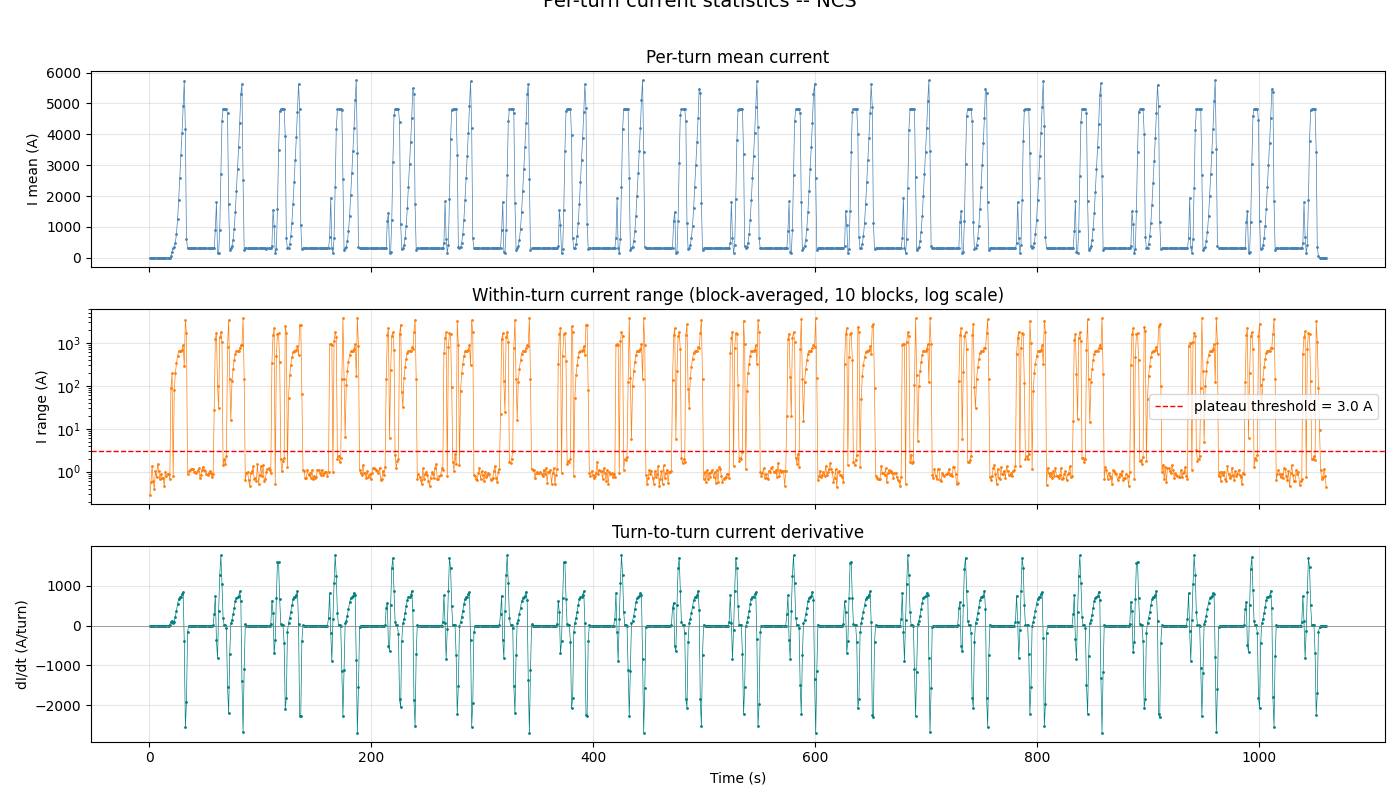

Total turns: 1061
I range: -0.2 .. 5750.4 A
Plateau-range values on flattest turns: [0.2813772  0.39759821 0.44276908 0.44559232 0.45829658] A


In [174]:
# Per-turn statistics
I_mean  = I_all.mean(axis=1)
t_mean  = t_all.mean(axis=1)

# Robust current range: block-averaged peak-to-peak per turn
N_BLOCKS = 10
I_range, I_blocks = compute_block_averaged_range(I_all, Ns, N_BLOCKS)

# Turn-to-turn dI/dt (for ramp detection)
dI_dt = np.gradient(I_mean)  # A/turn

fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

ax = axes[0]
ax.plot(t_mean, I_mean, ".-", markersize=2, linewidth=0.5, color="steelblue")
ax.set_ylabel("I mean (A)")
ax.set_title("Per-turn mean current")

ax = axes[1]
ax.semilogy(t_mean, I_range, ".-", markersize=2, linewidth=0.5, color="tab:orange")
ax.axhline(PLATEAU_I_RANGE_MAX, color="red", linestyle="--", linewidth=1,
           label=f"plateau threshold = {PLATEAU_I_RANGE_MAX} A")
ax.set_ylabel("I range (A)")
ax.set_title(f"Within-turn current range (block-averaged, {N_BLOCKS} blocks, log scale)")
ax.legend()

ax = axes[2]
ax.plot(t_mean, dI_dt, ".-", markersize=2, linewidth=0.5, color="teal")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_ylabel("dI/dt (A/turn)")
ax.set_xlabel("Time (s)")
ax.set_title("Turn-to-turn current derivative")

fig.suptitle(f"Per-turn current statistics -- {SEGMENT}", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print(f"Total turns: {n_turns}")
print(f"I range: {I_mean.min():.1f} .. {I_mean.max():.1f} A")
print(f"Plateau-range values on flattest turns: "
      f"{np.sort(I_range)[:5]} A")

---
## 4. Plateau Detection & Cycle Identification

**Plateau criterion:** a turn is on a current plateau if **all three**
conditions are met:

1. The within-turn standard deviation of the current is below the threshold
2. The turn **starts** on the plateau (first samples are close to the turn mean)
3. The turn **ends** on the plateau (last samples are close to the turn mean)

This ensures that only turns fully contained within a stable plateau are
accepted -- no ramp contamination at the boundaries.

Current levels are then clustered to identify:
- **Injection** (~300 A, SPS 26 GeV)
- **Flat-top high** (~4815 A)
- **Flat-top low** (~3290 A, appears every few supercycles)

Plateau detection: 604 turns accepted, 0 boundary-rejected

PASS / NO-PASS RULES  (threshold = 3.0 A)
  Rule (a)  block-averaged I range < 3.0 A
            current must be flat (noise-filtered peak-to-peak)
            -> 604 / 1061 turns pass
  Rule (b)  |I_first_block - I_mean| < 3.0 A
            turn must start on the plateau
            -> 604 / 604 (of range-ok) pass
  Rule (c)  |I_last_block - I_mean| < 3.0 A
            turn must end on the plateau
            -> 604 / 604 (of range-ok) pass
  ALL THREE -> 604 plateau turns
  Boundary-rejected (pass a, fail b or c): 0


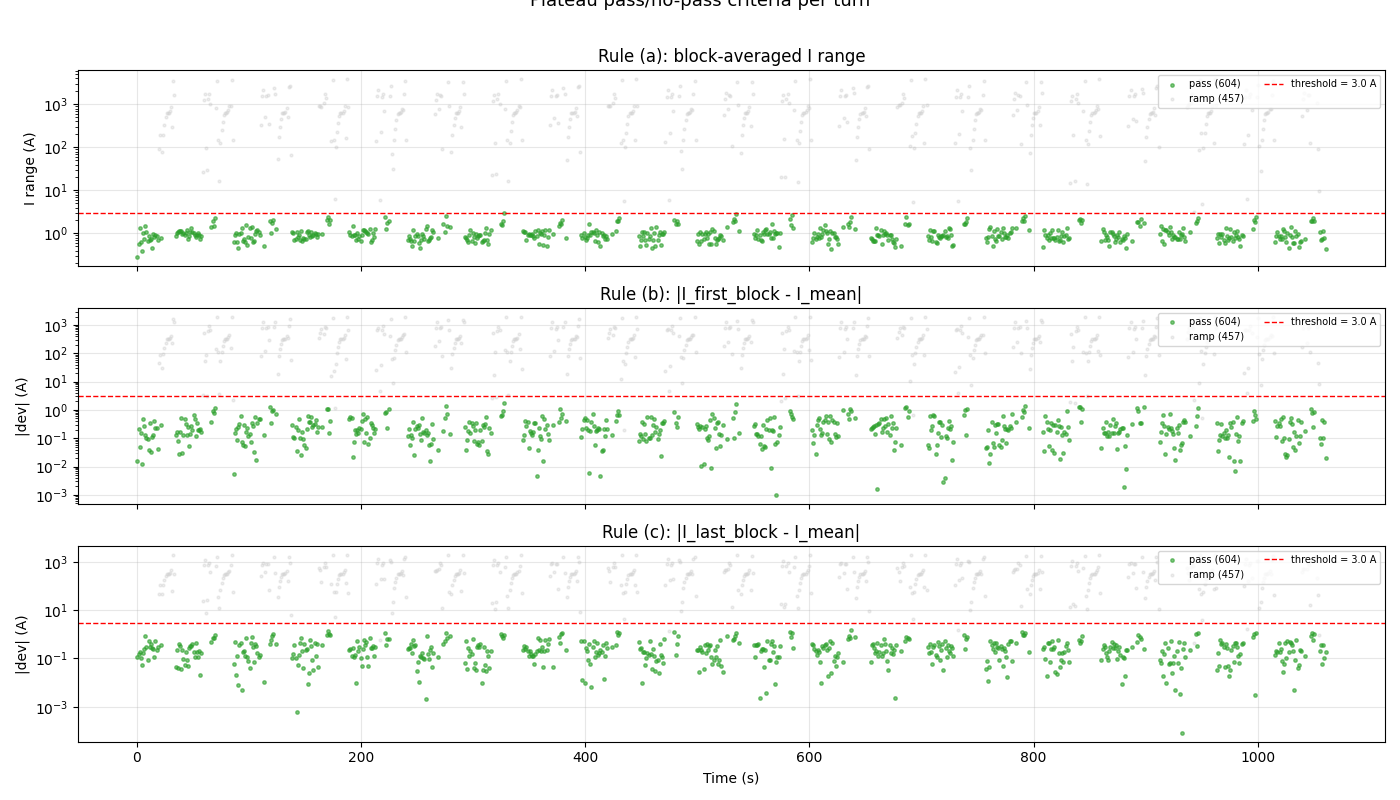


Turn classification:
  zero        :    25 turns, I =      0.0 +/-    0.1 A
  pre-ramp    :    12 turns, I =    160.9 +/-    0.1 A
  injection   :   488 turns, I =    300.9 +/-    0.2 A
  flat-high   :    79 turns, I =   4814.7 +/-    1.9 A
  ramp        :   457 turns, I =   2118.3 +/- 1754.8 A

  boundary-rej :     0 turns (flat range but ramp at start/end)

Turns for harmonic analysis: 567 / 1061


In [175]:
# --- Turn boundary times ---
t_start = t_all[:, 0]    # time of first sample of each turn
t_end   = t_all[:, -1]   # time of last sample of each turn

# --- Step 1: classify each turn as plateau or ramp ---
plateau_info = detect_plateau_turns(I_blocks, I_mean, I_range, PLATEAU_I_RANGE_MAX)
is_plateau = plateau_info["is_plateau"]
is_boundary_rejected = plateau_info["is_boundary_rejected"]
range_ok = plateau_info["range_ok"]
start_ok = plateau_info["start_ok"]
end_ok = plateau_info["end_ok"]

n_boundary_rejected = int(is_boundary_rejected.sum())
print(f"Plateau detection: {is_plateau.sum()} turns accepted, "
      f"{n_boundary_rejected} boundary-rejected")

# --- Pass / no-pass rules summary ---
print(f"\n{'='*70}")
print(f"PASS / NO-PASS RULES  (threshold = {PLATEAU_I_RANGE_MAX} A)")
print(f"{'='*70}")
print(f"  Rule (a)  block-averaged I range < {PLATEAU_I_RANGE_MAX} A")
print(f"            current must be flat (noise-filtered peak-to-peak)")
print(f"            -> {range_ok.sum()} / {n_turns} turns pass")
print(f"  Rule (b)  |I_first_block - I_mean| < {PLATEAU_I_RANGE_MAX} A")
print(f"            turn must start on the plateau")
print(f"            -> {(range_ok & start_ok).sum()} / {range_ok.sum()} (of range-ok) pass")
print(f"  Rule (c)  |I_last_block - I_mean| < {PLATEAU_I_RANGE_MAX} A")
print(f"            turn must end on the plateau")
print(f"            -> {(range_ok & end_ok).sum()} / {range_ok.sum()} (of range-ok) pass")
print(f"  ALL THREE -> {is_plateau.sum()} plateau turns")
print(f"  Boundary-rejected (pass a, fail b or c): {n_boundary_rejected}")

# --- Diagnostic: show the three criteria values per turn ---
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

I_start_edge = I_blocks[:, 0]
I_end_edge   = I_blocks[:, -1]
dev_start = np.abs(I_start_edge - I_mean)
dev_end   = np.abs(I_end_edge   - I_mean)

for ax, vals, title, ylabel in [
    (axes[0], I_range,   "Rule (a): block-averaged I range",          "I range (A)"),
    (axes[1], dev_start, "Rule (b): |I_first_block - I_mean|",        "|dev| (A)"),
    (axes[2], dev_end,   "Rule (c): |I_last_block - I_mean|",         "|dev| (A)"),
]:
    # pass turns
    ax.scatter(t_mean[is_plateau], vals[is_plateau],
               s=6, color="tab:green", alpha=0.6, label=f"pass ({is_plateau.sum()})", zorder=2)
    # boundary-rejected
    if is_boundary_rejected.sum() > 0:
        ax.scatter(t_mean[is_boundary_rejected], vals[is_boundary_rejected],
                   s=20, color="tab:orange", marker="x", linewidths=1,
                   label=f"boundary-rej ({is_boundary_rejected.sum()})", zorder=3)
    # ramp (fail range)
    ramp_mask = ~range_ok
    ax.scatter(t_mean[ramp_mask], vals[ramp_mask],
               s=4, color="lightgrey", alpha=0.4, label=f"ramp ({ramp_mask.sum()})", zorder=1)
    ax.axhline(PLATEAU_I_RANGE_MAX, color="red", linestyle="--", linewidth=1,
               label=f"threshold = {PLATEAU_I_RANGE_MAX} A")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yscale("log")
    ax.legend(fontsize=7, loc="upper right", ncol=2)

axes[-1].set_xlabel("Time (s)")
fig.suptitle("Plateau pass/no-pass criteria per turn", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# --- Step 2: cluster plateau turns by current level ---
turn_label = np.array(["ramp"] * n_turns, dtype=object)
for i in range(n_turns):
    if is_plateau[i]:
        turn_label[i] = classify_current(I_mean[i])

# Summary
label_counts = Counter(turn_label)
print("\nTurn classification:")
for label in ["zero", "pre-ramp", "injection", "flat-low", "flat-mid",
              "flat-high", "ramp"]:
    n = label_counts.get(label, 0)
    if n > 0:
        mask = turn_label == label
        I_vals = I_mean[mask]
        print(f"  {label:12s}: {n:5d} turns, "
              f"I = {I_vals.mean():8.1f} +/- {I_vals.std():6.1f} A")

print(f"\n  boundary-rej : {is_boundary_rejected.sum():5d} turns "
      f"(flat range but ramp at start/end)")

# Plateau turns suitable for harmonic analysis
analysis_labels = {"injection", "flat-mid", "flat-high"}
is_analysis = np.array([l in analysis_labels for l in turn_label])
print(f"\nTurns for harmonic analysis: {is_analysis.sum()} / {n_turns}")

In [176]:
# --- Step 3: identify the supercycle structure ---
# A supercycle = one injection plateau + the cycles that follow until
# the next injection plateau.

# Find contiguous injection groups
inj_mask = turn_label == "injection"
inj_groups = find_contiguous_groups(inj_mask, min_length=2)

print(f"Injection plateaus detected: {len(inj_groups)}")
if len(inj_groups) == 0:
    print("  WARNING: no injection plateaus found -- try raising PLATEAU_I_RANGE_MAX")

# Between consecutive injections, find flat-top groups
cycle_info = []
for gi in range(len(inj_groups)):
    inj_s, inj_e = inj_groups[gi]

    # Look at turns AFTER this injection (until next injection)
    if gi + 1 < len(inj_groups):
        next_inj_s = inj_groups[gi + 1][0]
    else:
        next_inj_s = n_turns

    # Find flat-top turns in the gap between injections
    gap_slice = slice(inj_e + 1, next_inj_s)
    gap_labels = turn_label[gap_slice]
    gap_I = I_mean[gap_slice]
    gap_t = t_mean[gap_slice]
    gap_indices = np.arange(inj_e + 1, next_inj_s)

    # Find flat-high turns in this gap
    fh_mask = gap_labels == "flat-high"
    fm_mask = gap_labels == "flat-mid"

    peak_I = gap_I.max() if len(gap_I) > 0 else 0

    cycle_type = "unknown"
    if fh_mask.sum() >= 2:
        cycle_type = "flat-high"
    elif fm_mask.sum() >= 2:
        cycle_type = "flat-mid"
    elif peak_I > 5000:
        cycle_type = "fast-ramp-high"  # ramps high but no detectable flat top
    elif peak_I > 3000:
        cycle_type = "fast-ramp-mid"

    # Record flat-top turn indices for averaging
    ft_indices = []
    ft_label = None
    if fh_mask.sum() > 0:
        ft_indices.extend(gap_indices[fh_mask].tolist())
        ft_label = "flat-high"
    if fm_mask.sum() > 0:
        ft_indices.extend(gap_indices[fm_mask].tolist())
        if ft_label is None:
            ft_label = "flat-mid"

    cycle_info.append({
        "inj_start": inj_s,
        "inj_end": inj_e,
        "inj_turns": inj_e - inj_s + 1,
        "gap_start": inj_e + 1,
        "gap_end": next_inj_s - 1,
        "peak_I": peak_I,
        "cycle_type": cycle_type,
        "ft_indices": ft_indices,
        "ft_label": ft_label,
        "n_ft_turns": len(ft_indices),
    })

if cycle_info:
    df_cycles = pd.DataFrame(cycle_info)

    print(f"\nCycles between injection plateaus: {len(df_cycles)}")
    print(f"\nCycle type summary:")
    for ct in ["flat-high", "flat-mid", "fast-ramp-high", "fast-ramp-mid", "unknown"]:
        sub = df_cycles[df_cycles["cycle_type"] == ct]
        if len(sub) > 0:
            print(f"  {ct:18s}: {len(sub):3d} cycles, "
                  f"peak I = {sub['peak_I'].mean():.0f} +/- {sub['peak_I'].std():.0f} A, "
                  f"flat-top turns/cycle = {sub['n_ft_turns'].mean():.1f}")

    # Flat-top statistics
    for lab in ["flat-high", "flat-mid"]:
        all_ft = []
        for _, row in df_cycles.iterrows():
            if row["ft_label"] == lab:
                all_ft.extend(row["ft_indices"])
        if all_ft:
            ft_arr = np.array(all_ft)
            print(f"\n{lab}: {len(ft_arr)} total flat-top turns, "
                  f"I = {I_mean[ft_arr].mean():.1f} +/- {I_mean[ft_arr].std():.1f} A")
else:
    df_cycles = pd.DataFrame()
    print("\nNo cycles detected (no injection plateaus found).")

Injection plateaus detected: 20

Cycles between injection plateaus: 20

Cycle type summary:
  flat-high         :  20 cycles, peak I = 5593 +/- 206 A, flat-top turns/cycle = 4.0

flat-high: 79 total flat-top turns, I = 4814.7 +/- 1.9 A


---
## 5. Raw Signals with Plateau Annotations

C:\Users\albellel\AppData\Local\Temp\ipykernel_21416\3547888031.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


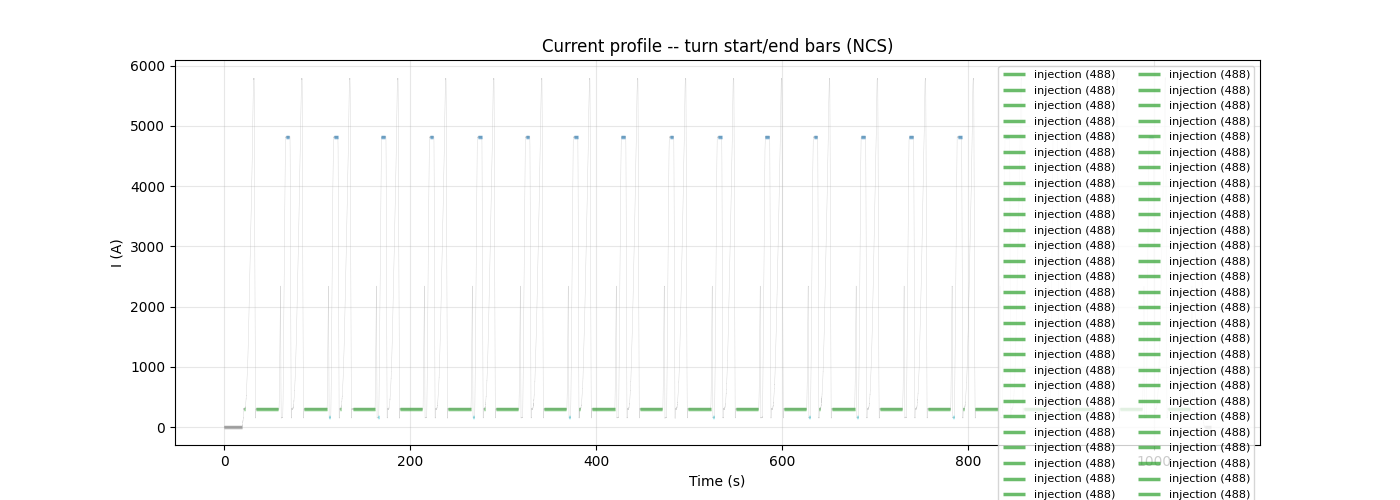

C:\Users\albellel\AppData\Local\Temp\ipykernel_21416\3547888031.py:91: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


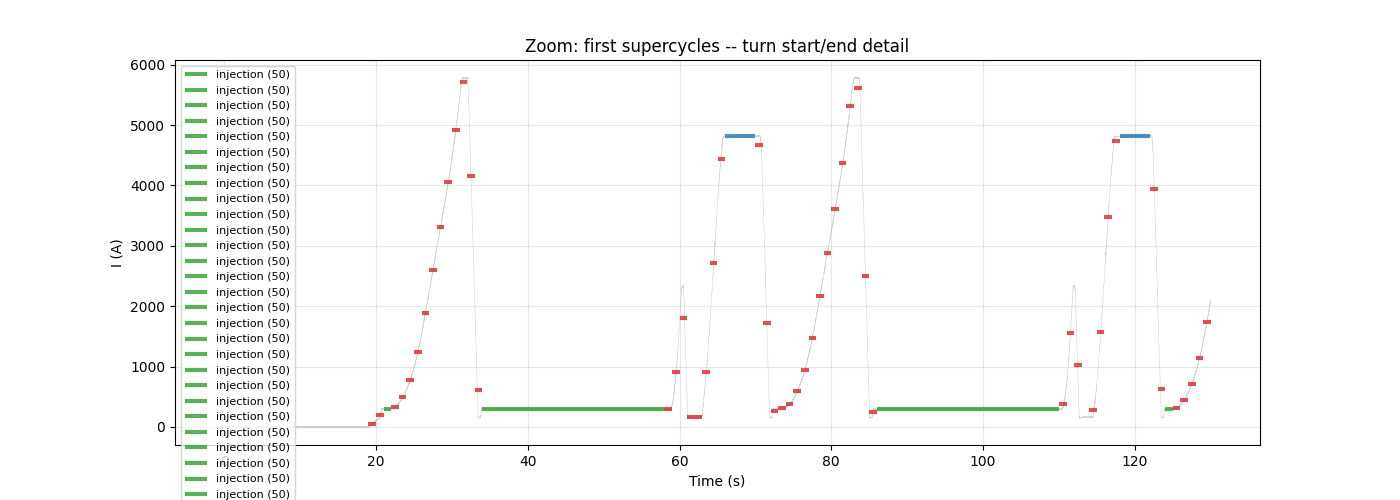

In [177]:
# --- Colors for turn classification ---
colors = {
    "injection": "tab:green",
    "flat-high": "tab:blue",
    "flat-mid": "tab:purple",
    "zero": "grey",
    "pre-ramp": "tab:cyan",
    "flat-low": "tab:olive",
    "ramp": "tab:red",
}

# =========================================================================
# Plot 1: Full view -- sample-level current with turn start/end bars
# =========================================================================
fig, ax = plt.subplots(figsize=(14, 5))

# Background: sample-level current (subsampled for speed)
step = max(1, n_keep // 80000)
ax.plot(raw[:n_keep:step, 0], raw[:n_keep:step, COL_I],
        linewidth=0.3, color="lightgrey", zorder=0)

# Draw each plateau turn as a horizontal bar from t_start to t_end
drawn_labels = set()
for label in ["injection", "flat-high", "flat-mid", "zero", "pre-ramp"]:
    mask = turn_label == label
    idx = np.where(mask)[0]
    if len(idx) == 0:
        continue
    col = colors[label]
    for j, ti in enumerate(idx):
        kw = dict(label=f"{label} ({len(idx)})") if label not in drawn_labels else {}
        ax.plot([t_start[ti], t_end[ti]], [I_mean[ti], I_mean[ti]],
                linewidth=2.5, color=col, alpha=0.7, solid_capstyle="butt",
                zorder=2, **kw)
    drawn_labels.add(label)

# Boundary-rejected turns as dashed bars
br_idx = np.where(is_boundary_rejected)[0]
if len(br_idx) > 0:
    for j, ti in enumerate(br_idx):
        kw = dict(label=f"boundary-rej ({len(br_idx)})") if j == 0 else {}
        ax.plot([t_start[ti], t_end[ti]], [I_mean[ti], I_mean[ti]],
                linewidth=2.5, color="red", alpha=0.6, linestyle="--",
                solid_capstyle="butt", zorder=3, **kw)

ax.set_xlabel("Time (s)")
ax.set_ylabel("I (A)")
ax.set_title(f"Current profile -- turn start/end bars ({SEGMENT})")
ax.legend(loc="upper right", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# =========================================================================
# Plot 2: Zoom -- first ~2 supercycles, turn bars visible
# =========================================================================
fig, ax = plt.subplots(figsize=(14, 5))

# Zoom time window
t_zoom_max = 130  # seconds
zoom_samp = raw[:n_keep, 0] < t_zoom_max
ax.plot(raw[:n_keep, 0][zoom_samp], raw[:n_keep, COL_I][zoom_samp],
        linewidth=0.4, color="lightgrey", zorder=0)

drawn_labels = set()
for label in ["injection", "flat-high", "flat-mid", "ramp"]:
    mask = (turn_label == label) & (t_mean < t_zoom_max)
    idx = np.where(mask)[0]
    if len(idx) == 0:
        continue
    col = colors[label]
    for j, ti in enumerate(idx):
        kw = dict(label=f"{label} ({len(idx)})") if label not in drawn_labels else {}
        ax.plot([t_start[ti], t_end[ti]], [I_mean[ti], I_mean[ti]],
                linewidth=3, color=col, alpha=0.8, solid_capstyle="butt",
                zorder=2, **kw)
    drawn_labels.add(label)

# Boundary-rejected in zoom
br_zoom_idx = np.where(is_boundary_rejected & (t_mean < t_zoom_max))[0]
if len(br_zoom_idx) > 0:
    for j, ti in enumerate(br_zoom_idx):
        kw = dict(label=f"boundary-rej ({len(br_zoom_idx)})") if j == 0 else {}
        ax.plot([t_start[ti], t_end[ti]], [I_mean[ti], I_mean[ti]],
                linewidth=3, color="red", alpha=0.7, linestyle="--",
                solid_capstyle="butt", zorder=3, **kw)

ax.set_xlabel("Time (s)")
ax.set_ylabel("I (A)")
ax.set_title("Zoom: first supercycles -- turn start/end detail")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

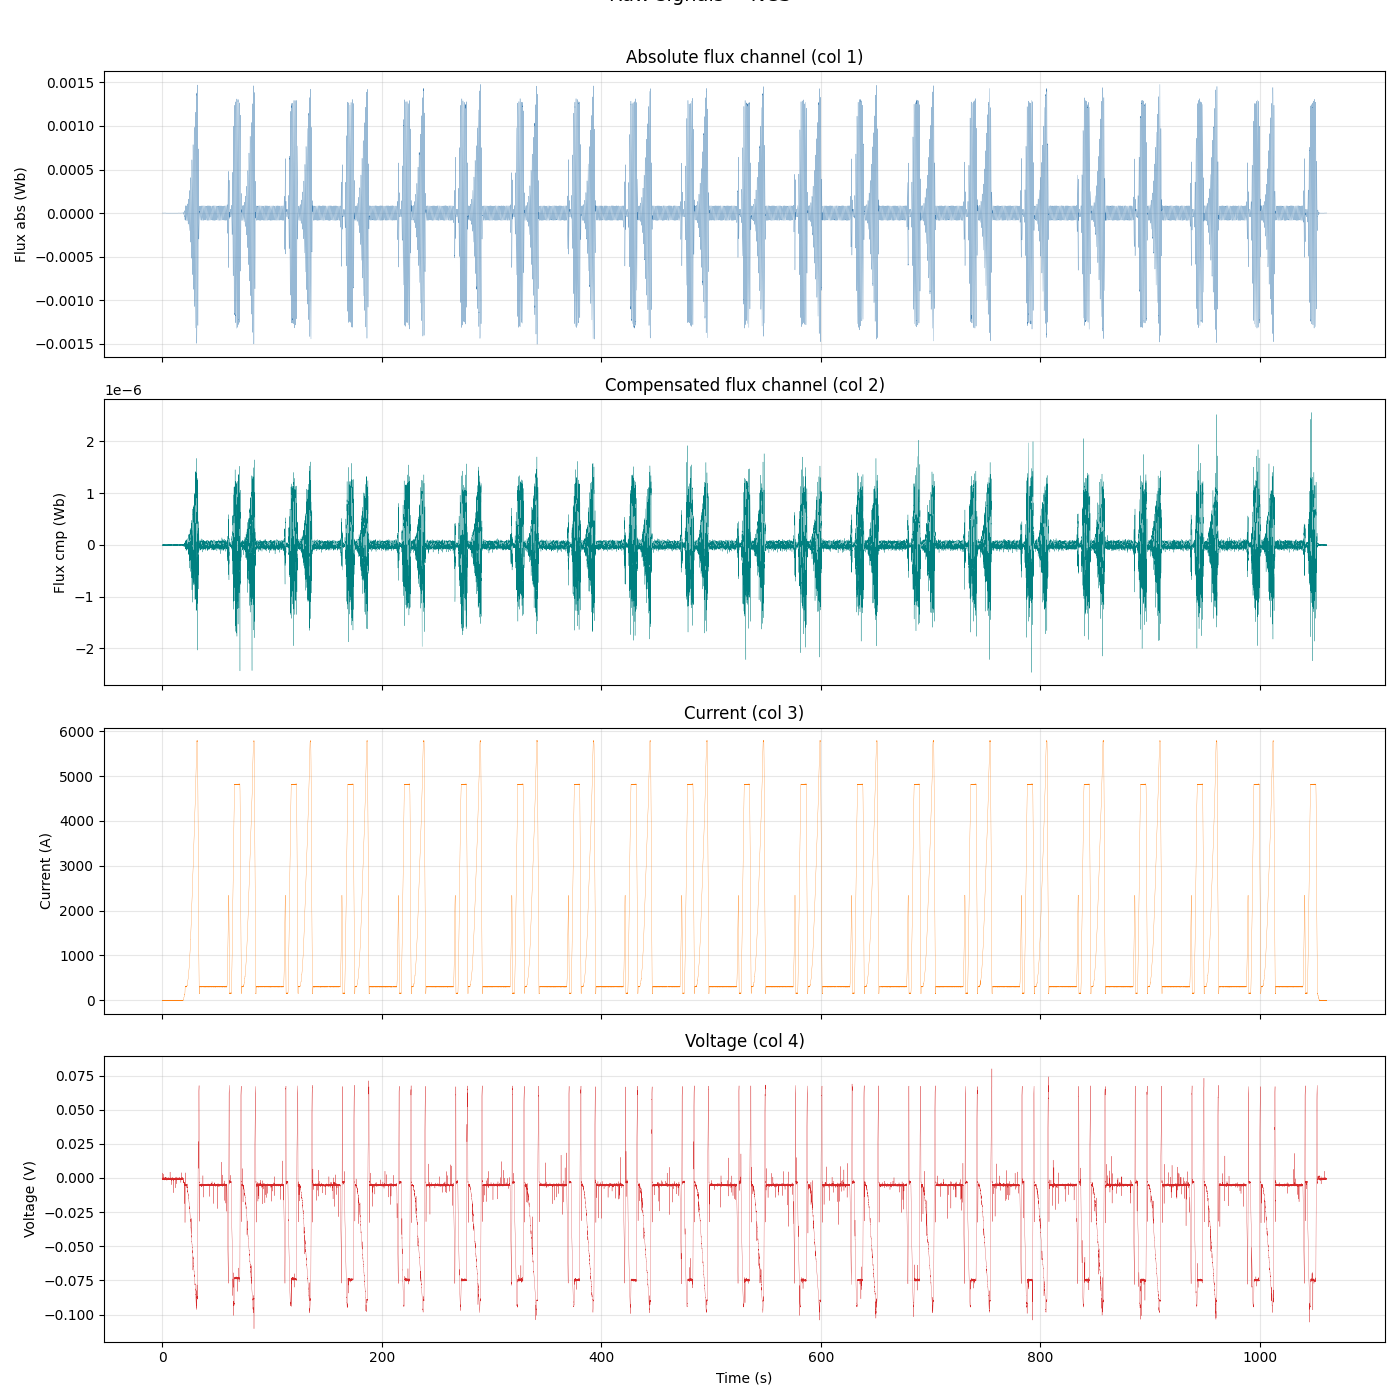

In [178]:
# Time series of all raw signals
has_voltage = V_all is not None
n_plots = 4 if has_voltage else 3
fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3.5 * n_plots), sharex=True)

# Concatenated sample-level view (subsample for speed)
step = max(1, n_keep // 50000)
x = raw[:n_keep:step, 0]

ax = axes[0]
ax.plot(x, raw[:n_keep:step, COL_ABS], linewidth=0.2, color="steelblue")
ax.set_ylabel("Flux abs (Wb)")
ax.set_title(f"Absolute flux channel (col {COL_ABS})")

ax = axes[1]
ax.plot(x, raw[:n_keep:step, COL_CMP], linewidth=0.2, color="teal")
ax.set_ylabel("Flux cmp (Wb)")
ax.set_title(f"Compensated flux channel (col {COL_CMP})")

ax = axes[2]
ax.plot(x, raw[:n_keep:step, COL_I], linewidth=0.2, color="tab:orange")
ax.set_ylabel("Current (A)")
ax.set_title(f"Current (col {COL_I})")

if has_voltage:
    ax = axes[3]
    ax.plot(x, raw[:n_keep:step, COL_V], linewidth=0.2, color="tab:red")
    ax.set_ylabel("Voltage (V)")
    ax.set_title(f"Voltage (col {COL_V})")

axes[-1].set_xlabel("Time (s)")
fig.suptitle(f"Raw signals -- {SEGMENT}", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

---
## 6. Pipeline Processing (Plateau Turns Only)

Only turns classified as **injection**, **flat-high**, or **flat-mid**
are processed through the harmonic pipeline.  Ramp turns are excluded.

In [179]:
m = MAGNET_ORDER
MAX_ZR = 0.01

def process_turns(turn_indices, drift_mode="legacy"):
    '''Process selected turns through the Kn pipeline.'''
    idx = np.array(turn_indices)
    n = len(idx)
    if n == 0:
        return []

    result, C_merged, C_units, ok_main = process_kn_pipeline(
        flux_abs_turns=flux_abs_all[idx],
        flux_cmp_turns=flux_cmp_all[idx],
        t_turns=t_all[idx],
        I_turns=I_all[idx],
        kn=kn,
        r_ref=R_REF,
        magnet_order=m,
        options=OPTIONS,
        drift_mode=drift_mode,
        min_b1_T=MIN_B1_T,
        max_zr=MAX_ZR,
    )

    # Build extra columns specific to this notebook
    extra = [
        {
            "global_turn": int(idx[t]),
            "I_range_A": float(I_range[idx[t]]),
            "label": str(turn_label[idx[t]]),
        }
        for t in range(n)
    ]

    return build_harmonic_rows(result, C_merged, C_units, ok_main, m, extra)

# Collect all plateau turn indices
plateau_indices = np.where(is_analysis)[0]
print(f"Processing {len(plateau_indices)} plateau turns (of {n_turns} total)...")

if len(plateau_indices) == 0:
    print("\nWARNING: no plateau turns to process!")
    print(f"  Try raising PLATEAU_I_RANGE_MAX (currently {PLATEAU_I_RANGE_MAX} A)")
    df_L = pd.DataFrame()
    df_W = pd.DataFrame()
else:
    rows_L = process_turns(plateau_indices, "legacy")
    rows_W = process_turns(plateau_indices, "weighted")

    df_L = pd.DataFrame(rows_L)
    df_W = pd.DataFrame(rows_W)

    print(f"\nProcessed: {len(df_L)} turns")
    for lab in sorted(df_L["label"].unique()):
        sub = df_L[df_L["label"] == lab]
        print(f"  {lab:12s}: {len(sub):5d} turns, "
              f"I = {sub['I_mean_A'].mean():.1f} +/- {sub['I_mean_A'].std():.1f} A, "
              f"ok_main: {sub['ok_main'].sum()}/{len(sub)}")

Processing 567 plateau turns (of 1061 total)...

Processed: 567 turns
  flat-high   :    79 turns, I = 4814.7 +/- 1.9 A, ok_main: 79/79
  injection   :   488 turns, I = 300.9 +/- 0.2 A, ok_main: 488/488


---
## 7. Main Field (B1) per Plateau

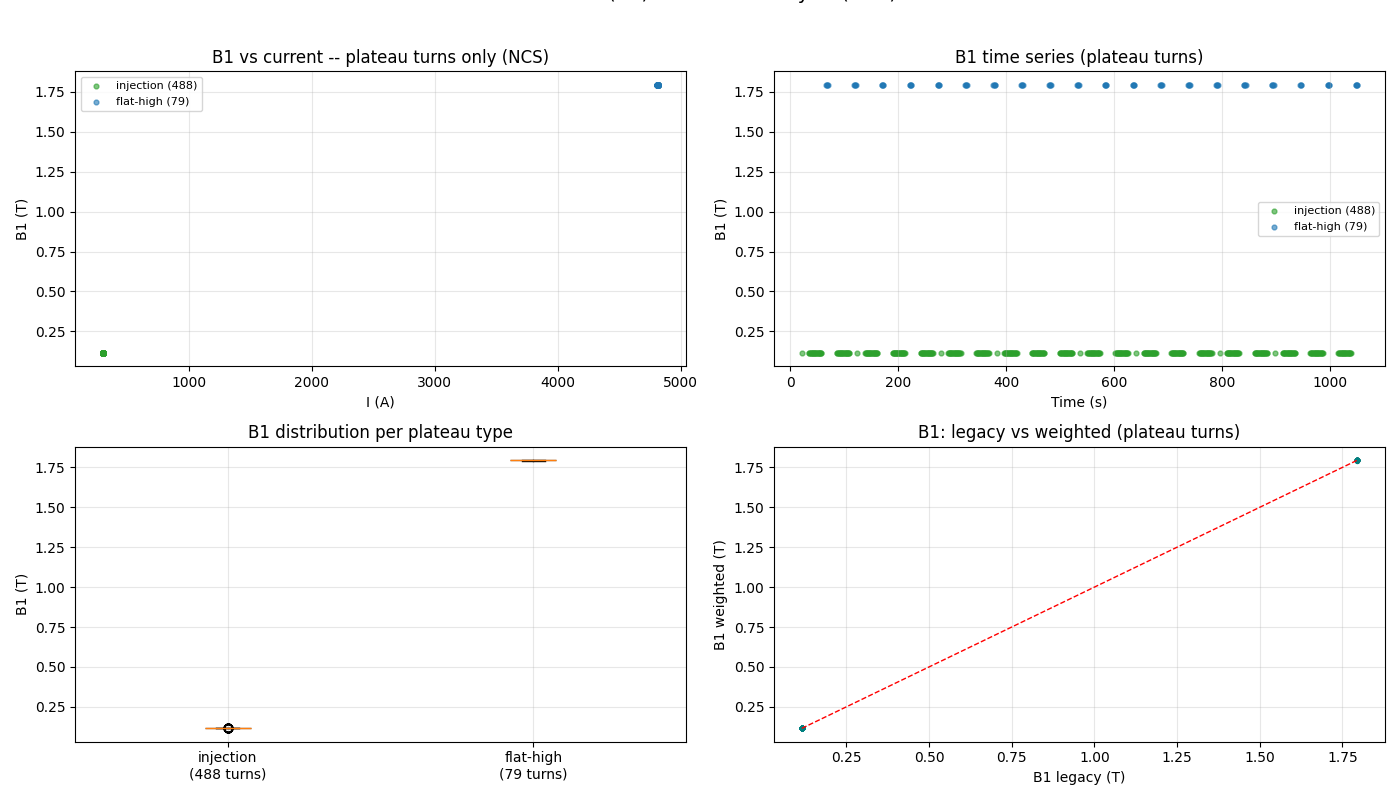


B1 per plateau type (legacy, ok_main only):
     Plateau     N    B1 mean (T)   B1 std (T)   I mean (A)
------------------------------------------------------------
   injection   488      +0.115640     0.000066        300.9
   flat-high    79      +1.793738     0.000492       4814.7


In [180]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    label_colors = {"injection": "tab:green", "flat-high": "tab:blue", "flat-mid": "tab:purple"}
    
    # (a) B1 vs I, coloured by plateau type
    ax = axes[0, 0]
    for lab, col in label_colors.items():
        mask = df_L["label"] == lab
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "I_mean_A"], df_L.loc[mask, "B1_T"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.set_xlabel("I (A)")
    ax.set_ylabel("B1 (T)")
    ax.set_title(f"B1 vs current -- plateau turns only ({SEGMENT})")
    ax.legend(fontsize=8)
    
    # (b) B1 time series
    ax = axes[0, 1]
    for lab, col in label_colors.items():
        mask = df_L["label"] == lab
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "time_s"], df_L.loc[mask, "B1_T"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("B1 (T)")
    ax.set_title("B1 time series (plateau turns)")
    ax.legend(fontsize=8)
    
    # (c) B1 per plateau type: box plot
    ax = axes[1, 0]
    box_data = []
    box_labels_list = []
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & df_L["ok_main"]
        vals = df_L.loc[mask, "B1_T"].values
        if len(vals) > 0:
            box_data.append(vals)
            box_labels_list.append(f"{lab}\n({len(vals)} turns)")
    if box_data:
        bp = ax.boxplot(box_data, tick_labels=box_labels_list, patch_artist=True)
        for patch, lab in zip(bp["boxes"], ["injection", "flat-mid", "flat-high"]):
            if lab in label_colors:
                patch.set_facecolor(label_colors[lab])
                patch.set_alpha(0.6)
    ax.set_ylabel("B1 (T)")
    ax.set_title("B1 distribution per plateau type")
    
    # (d) B1 legacy vs weighted
    ax = axes[1, 1]
    ok = df_L["ok_main"].values
    ax.scatter(df_L.loc[ok, "B1_T"], df_W.loc[ok, "B1_T"], s=8, alpha=0.5, c="teal")
    lims = [df_L.loc[ok, "B1_T"].min(), df_L.loc[ok, "B1_T"].max()]
    ax.plot(lims, lims, "r--", linewidth=1)
    ax.set_xlabel("B1 legacy (T)")
    ax.set_ylabel("B1 weighted (T)")
    ax.set_title("B1: legacy vs weighted (plateau turns)")
    
    fig.suptitle(f"Main Field (B1) -- Plateau Analysis ({SEGMENT})", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Per-plateau-type statistics
    print("\nB1 per plateau type (legacy, ok_main only):")
    print(f"{'Plateau':>12s} {'N':>5s} {'B1 mean (T)':>14s} {'B1 std (T)':>12s} "
          f"{'I mean (A)':>12s}")
    print("-" * 60)
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & df_L["ok_main"]
        if mask.sum() == 0:
            continue
        B1 = df_L.loc[mask, "B1_T"].values
        I_v = df_L.loc[mask, "I_mean_A"].values
        print(f"{lab:>12s} {mask.sum():5d} {B1.mean():+14.6f} {B1.std():12.6f} "
              f"{I_v.mean():12.1f}")

---
## 8. Transfer Function B/I vs I

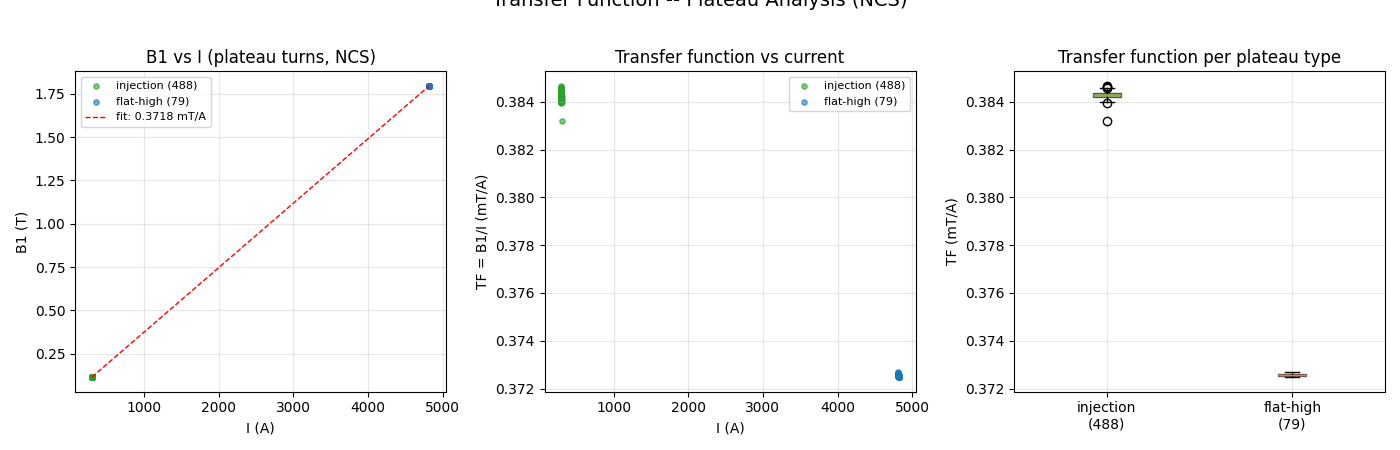


Transfer function per plateau type:
     Plateau     N   TF mean (mT/A)  TF std (mT/A)
----------------------------------------------------
   injection   488         0.384269       0.000125
   flat-high    79         0.372556       0.000046


In [181]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    ok_tf = df_L["ok_main"] & (df_L["I_mean_A"] > 50)
    I_tf = df_L.loc[ok_tf, "I_mean_A"].values
    B1_tf = df_L.loc[ok_tf, "B1_T"].values
    TF = B1_tf / I_tf  # T/A
    labels_tf = df_L.loc[ok_tf, "label"].values
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
    
    # (a) B1 vs I with linear fit
    ax = axes[0]
    for lab, col in label_colors.items():
        m_lab = labels_tf == lab
        if m_lab.sum() > 0:
            ax.scatter(I_tf[m_lab], B1_tf[m_lab], s=15, alpha=0.6, color=col,
                       label=f"{lab} ({m_lab.sum()})")
    if len(I_tf) > 2:
        coeffs = np.polyfit(I_tf, B1_tf, 1)
        I_fit = np.linspace(I_tf.min(), I_tf.max(), 100)
        ax.plot(I_fit, np.polyval(coeffs, I_fit), "r--", linewidth=1,
                label=f"fit: {coeffs[0]*1e3:.4f} mT/A")
    ax.set_xlabel("I (A)")
    ax.set_ylabel("B1 (T)")
    ax.set_title(f"B1 vs I (plateau turns, {SEGMENT})")
    ax.legend(fontsize=8)
    
    # (b) TF vs I
    ax = axes[1]
    for lab, col in label_colors.items():
        m_lab = labels_tf == lab
        if m_lab.sum() > 0:
            ax.scatter(I_tf[m_lab], TF[m_lab] * 1e3, s=15, alpha=0.6, color=col,
                       label=f"{lab} ({m_lab.sum()})")
    ax.set_xlabel("I (A)")
    ax.set_ylabel("TF = B1/I (mT/A)")
    ax.set_title("Transfer function vs current")
    ax.legend(fontsize=8)
    
    # (c) TF per plateau type
    ax = axes[2]
    tf_data = []
    tf_labels = []
    for lab in ["injection", "flat-mid", "flat-high"]:
        m_lab = labels_tf == lab
        if m_lab.sum() > 0:
            tf_data.append(TF[m_lab] * 1e3)
            tf_labels.append(f"{lab}\n({m_lab.sum()})")
    if tf_data:
        bp = ax.boxplot(tf_data, tick_labels=tf_labels, patch_artist=True)
        for patch, lab in zip(bp["boxes"], ["injection", "flat-mid", "flat-high"]):
            if lab in label_colors:
                patch.set_facecolor(label_colors[lab])
                patch.set_alpha(0.6)
    ax.set_ylabel("TF (mT/A)")
    ax.set_title("Transfer function per plateau type")
    
    fig.suptitle(f"Transfer Function -- Plateau Analysis ({SEGMENT})", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Table
    print("\nTransfer function per plateau type:")
    print(f"{'Plateau':>12s} {'N':>5s} {'TF mean (mT/A)':>16s} {'TF std (mT/A)':>14s}")
    print("-" * 52)
    for lab in ["injection", "flat-mid", "flat-high"]:
        m_lab = labels_tf == lab
        if m_lab.sum() == 0:
            continue
        tf_v = TF[m_lab] * 1e3
        print(f"{lab:>12s} {m_lab.sum():5d} {tf_v.mean():16.6f} {tf_v.std():14.6f}")

---
## 9. b2 (Quadrupole) per Plateau

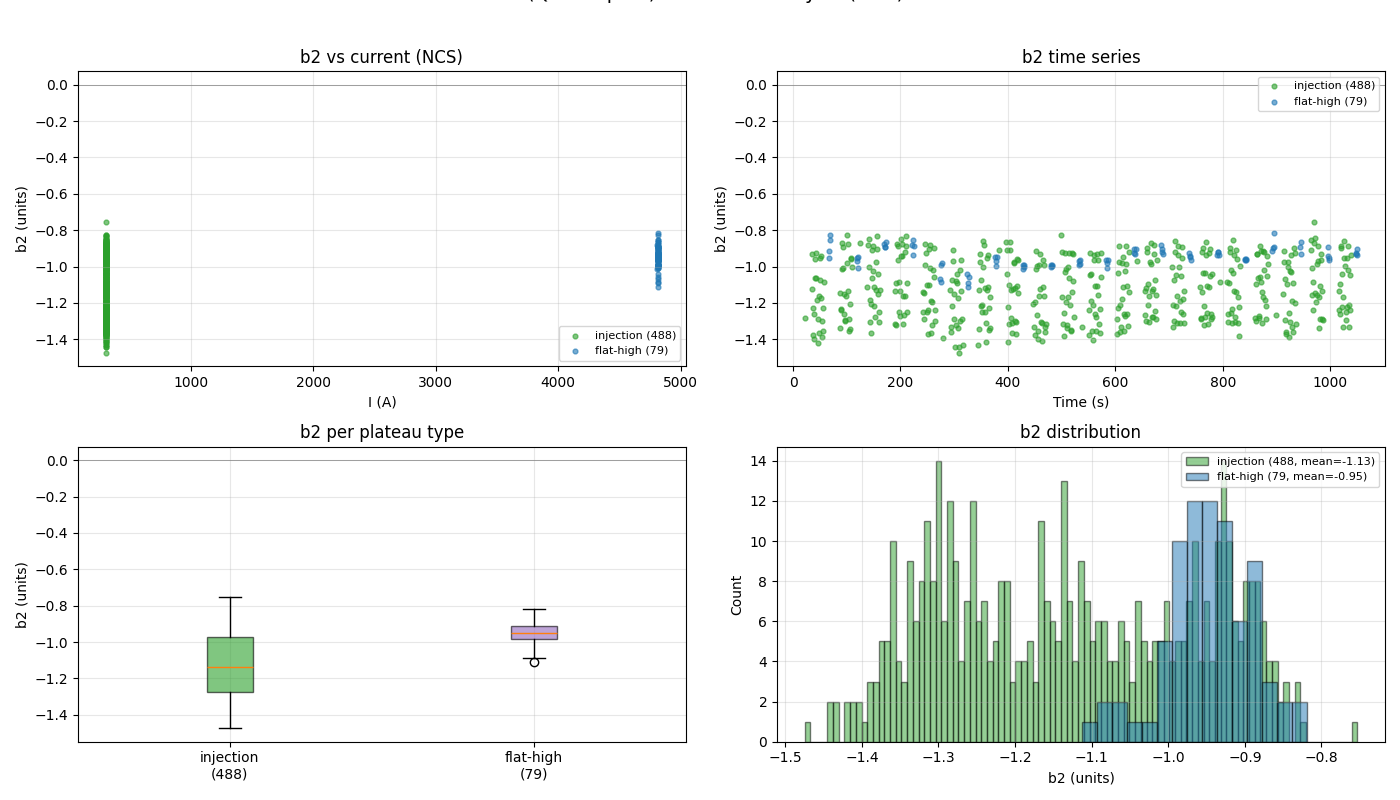


b2 per plateau type (legacy, ok_main):
     Plateau     N       mean        std     median
--------------------------------------------------
   injection   488    -1.1287     0.1644    -1.1367
   flat-high    79    -0.9481     0.0567    -0.9481


In [182]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    ok_norm = df_L["ok_main"].values
    
    # (a) b2 vs I
    ax = axes[0, 0]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "I_mean_A"], df_L.loc[mask, "b2_units"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("I (A)")
    ax.set_ylabel("b2 (units)")
    ax.set_title(f"b2 vs current ({SEGMENT})")
    ax.legend(fontsize=8)
    
    # (b) b2 time series
    ax = axes[0, 1]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "time_s"], df_L.loc[mask, "b2_units"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("b2 (units)")
    ax.set_title("b2 time series")
    ax.legend(fontsize=8)
    
    # (c) b2 box plot per plateau
    ax = axes[1, 0]
    box_data = []
    box_labels_list = []
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b2_units"])
        vals = df_L.loc[mask, "b2_units"].values
        if len(vals) > 0:
            box_data.append(vals)
            box_labels_list.append(f"{lab}\n({len(vals)})")
    if box_data:
        bp = ax.boxplot(box_data, tick_labels=box_labels_list, patch_artist=True)
        for patch, lab in zip(bp["boxes"], ["injection", "flat-mid", "flat-high"]):
            if lab in label_colors:
                patch.set_facecolor(label_colors[lab])
                patch.set_alpha(0.6)
    ax.set_ylabel("b2 (units)")
    ax.set_title("b2 per plateau type")
    ax.axhline(0, color="grey", linewidth=0.5)
    
    # (d) b2 histogram per plateau
    ax = axes[1, 1]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b2_units"])
        vals = df_L.loc[mask, "b2_units"].values
        if len(vals) > 0:
            ax.hist(vals, bins=max(10, len(vals) // 5), alpha=0.5,
                    color=col, label=f"{lab} ({len(vals)}, mean={vals.mean():.2f})",
                    edgecolor="black")
    ax.set_xlabel("b2 (units)")
    ax.set_ylabel("Count")
    ax.set_title("b2 distribution")
    ax.legend(fontsize=8)
    
    fig.suptitle(f"b2 (Quadrupole) -- Plateau Analysis ({SEGMENT})", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Table
    print("\nb2 per plateau type (legacy, ok_main):")
    print(f"{'Plateau':>12s} {'N':>5s} {'mean':>10s} {'std':>10s} {'median':>10s}")
    print("-" * 50)
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b2_units"])
        vals = df_L.loc[mask, "b2_units"].values
        if len(vals) == 0:
            continue
        print(f"{lab:>12s} {len(vals):5d} {vals.mean():+10.4f} "
              f"{vals.std():10.4f} {np.median(vals):+10.4f}")

---
## 10. b3 (Sextupole) per Plateau

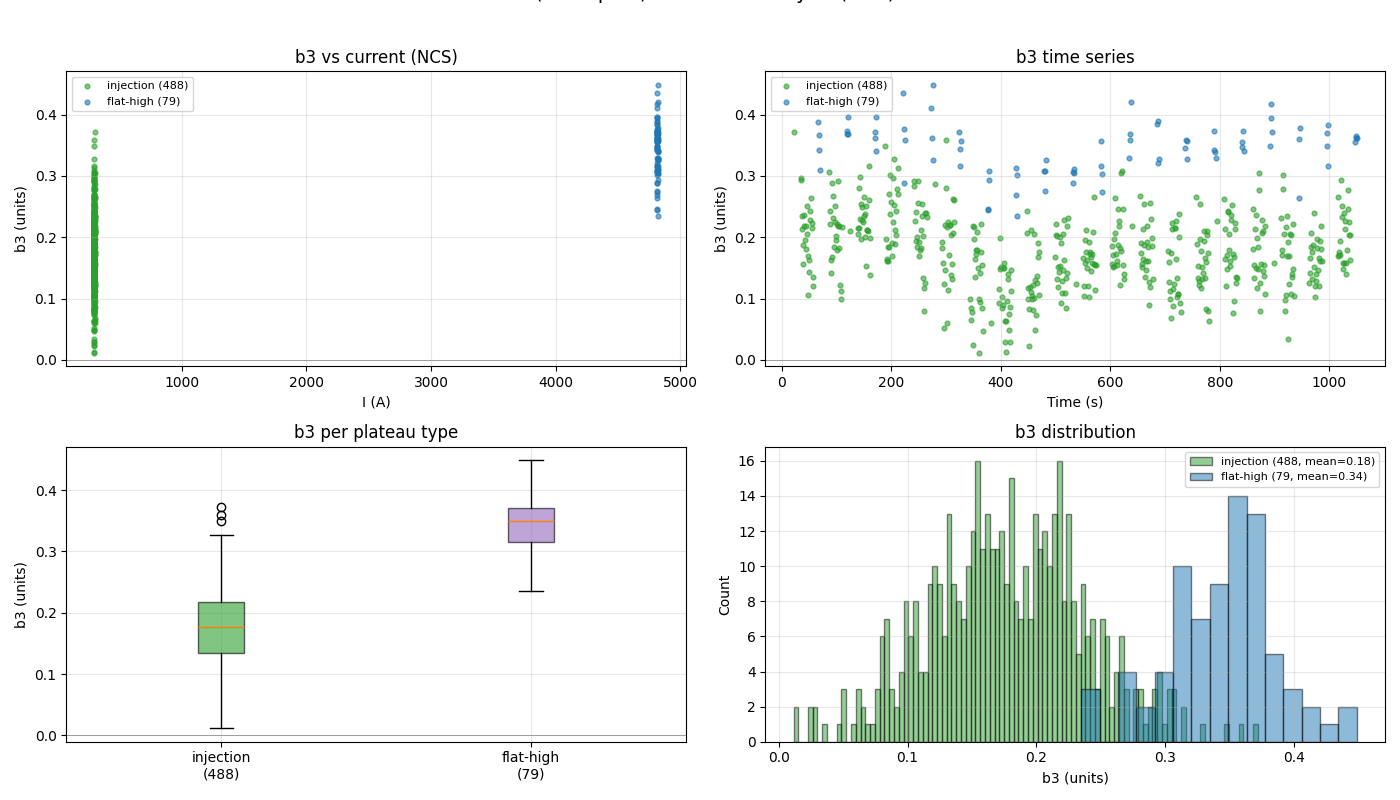


b3 per plateau type (legacy, ok_main):
     Plateau     N       mean        std     median
--------------------------------------------------
   injection   488    +0.1772     0.0611    +0.1761
   flat-high    79    +0.3438     0.0427    +0.3497


In [183]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # (a) b3 vs I
    ax = axes[0, 0]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "I_mean_A"], df_L.loc[mask, "b3_units"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("I (A)")
    ax.set_ylabel("b3 (units)")
    ax.set_title(f"b3 vs current ({SEGMENT})")
    ax.legend(fontsize=8)
    
    # (b) b3 time series
    ax = axes[0, 1]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm
        if mask.sum() > 0:
            ax.scatter(df_L.loc[mask, "time_s"], df_L.loc[mask, "b3_units"],
                       s=12, alpha=0.6, color=col, label=f"{lab} ({mask.sum()})")
    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("b3 (units)")
    ax.set_title("b3 time series")
    ax.legend(fontsize=8)
    
    # (c) b3 box plot per plateau
    ax = axes[1, 0]
    box_data = []
    box_labels_list = []
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b3_units"])
        vals = df_L.loc[mask, "b3_units"].values
        if len(vals) > 0:
            box_data.append(vals)
            box_labels_list.append(f"{lab}\n({len(vals)})")
    if box_data:
        bp = ax.boxplot(box_data, tick_labels=box_labels_list, patch_artist=True)
        for patch, lab in zip(bp["boxes"], ["injection", "flat-mid", "flat-high"]):
            if lab in label_colors:
                patch.set_facecolor(label_colors[lab])
                patch.set_alpha(0.6)
    ax.set_ylabel("b3 (units)")
    ax.set_title("b3 per plateau type")
    ax.axhline(0, color="grey", linewidth=0.5)
    
    # (d) b3 histogram per plateau
    ax = axes[1, 1]
    for lab, col in label_colors.items():
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b3_units"])
        vals = df_L.loc[mask, "b3_units"].values
        if len(vals) > 0:
            ax.hist(vals, bins=max(10, len(vals) // 5), alpha=0.5,
                    color=col, label=f"{lab} ({len(vals)}, mean={vals.mean():.2f})",
                    edgecolor="black")
    ax.set_xlabel("b3 (units)")
    ax.set_ylabel("Count")
    ax.set_title("b3 distribution")
    ax.legend(fontsize=8)
    
    fig.suptitle(f"b3 (Sextupole) -- Plateau Analysis ({SEGMENT})", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Table
    print("\nb3 per plateau type (legacy, ok_main):")
    print(f"{'Plateau':>12s} {'N':>5s} {'mean':>10s} {'std':>10s} {'median':>10s}")
    print("-" * 50)
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & ok_norm & np.isfinite(df_L["b3_units"])
        vals = df_L.loc[mask, "b3_units"].values
        if len(vals) == 0:
            continue
        print(f"{lab:>12s} {len(vals):5d} {vals.mean():+10.4f} "
              f"{vals.std():10.4f} {np.median(vals):+10.4f}")

---
## 11. Summary & Export

In [184]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    print("=" * 70)
    print(f"SPS MBB DIPOLE -- {SEGMENT} STREAMING SUPERCYCLE ANALYSIS")
    print("=" * 70)
    
    print(f"\nMeasurement     : {SESSION}")
    print(f"Kn calibration  : {KN_PATH.name} (cross-session from MBA)")
    print(f"Total turns     : {n_turns}")
    print(f"Plateau turns   : {is_analysis.sum()} (I range < {PLATEAU_I_RANGE_MAX} A)")
    print(f"Ramp turns      : {n_turns - is_analysis.sum()} (excluded)")
    print(f"Time span       : {t_mean[-1] - t_mean[0]:.1f} s")
    
    print(f"\n{'─'*70}")
    print(f"{'Plateau':>12s} {'N':>5s} {'I (A)':>10s} {'B1 (T)':>12s} "
          f"{'TF (mT/A)':>12s} {'b2 (u)':>10s} {'b3 (u)':>10s}")
    print(f"{'─'*70}")
    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = (df_L["label"] == lab) & df_L["ok_main"]
        if mask.sum() == 0:
            continue
        sub = df_L[mask]
        I_v = sub["I_mean_A"].values
        B1 = sub["B1_T"].values
        tf = B1 / I_v * 1e3
        b2 = sub["b2_units"].values
        b3 = sub["b3_units"].values
        b2_ok = b2[np.isfinite(b2)]
        b3_ok = b3[np.isfinite(b3)]
        print(f"{lab:>12s} {mask.sum():5d} {I_v.mean():10.1f} {B1.mean():+12.6f} "
              f"{tf.mean():12.4f} "
              f"{b2_ok.mean() if len(b2_ok) else float('nan'):+10.4f} "
              f"{b3_ok.mean() if len(b3_ok) else float('nan'):+10.4f}")
    
    # Drift comparison
    print(f"\n--- Drift Correction (legacy vs weighted) ---")
    for name, col in [("B1", "B1_T"), ("b2", "b2_units"), ("b3", "b3_units")]:
        if col not in df_L.columns:
            continue
        vL = df_L.loc[df_L["ok_main"], col].values
        vW = df_W.loc[df_W["ok_main"], col].values
        ok = np.isfinite(vL) & np.isfinite(vW)
        if ok.sum() > 0:
            d = vW[ok] - vL[ok]
            unit = "T" if "T" in col else "units"
            print(f"  {name:3s} RMS diff: {np.sqrt(np.mean(d**2)):.6e} {unit}")

SPS MBB DIPOLE -- NCS STREAMING SUPERCYCLE ANALYSIS

Measurement     : 2026_02_06/01_200_extended/20260206_144537_SPS_MBB
Kn calibration  : Kn_values_Seg_Main_A_AC.txt (cross-session from MBA)
Total turns     : 1061
Plateau turns   : 567 (I range < 3.0 A)
Ramp turns      : 494 (excluded)
Time span       : 1060.0 s

──────────────────────────────────────────────────────────────────────
     Plateau     N      I (A)       B1 (T)    TF (mT/A)     b2 (u)     b3 (u)
──────────────────────────────────────────────────────────────────────
   injection   488      300.9    +0.115640       0.3843    -1.1287    +0.1772
   flat-high    79     4814.7    +1.793738       0.3726    -0.9481    +0.3438

--- Drift Correction (legacy vs weighted) ---
  B1  RMS diff: 8.529866e-08 T
  b2  RMS diff: 3.721582e-04 units
  b3  RMS diff: 1.581153e-04 units


In [185]:
if len(df_L) == 0:
    print("No plateau turns -- skipping. Raise PLATEAU_I_RANGE_MAX and re-run.")
else:
    out_dir = REPO_ROOT / "output" / SESSION
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for label, df_out in [("legacy", df_L), ("weighted", df_W)]:
        fname = f"MBB_{SEGMENT}_streaming_plateau_{label}.csv"
        df_out.to_csv(out_dir / fname, index=False)
        print(f"Wrote {out_dir / fname}  ({len(df_out)} rows)")
    
    print("\nDone.")

Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\01_200_extended\20260206_144537_SPS_MBB\MBB_NCS_streaming_plateau_legacy.csv  (567 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\01_200_extended\20260206_144537_SPS_MBB\MBB_NCS_streaming_plateau_weighted.csv  (567 rows)

Done.
